Shape of X : (569, 30)
Classes: ['malignant' 'benign']
Class distribution:
 target
1    357
0    212
Name: count, dtype: int64
Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}
Best cross-val accuracy: 0.958
Test Accuracy: 0.941
Classification Report:
              precision    recall  f1-score   support

   malignant       0.93      0.91      0.92        70
      benign       0.95      0.96      0.95       118

    accuracy                           0.94       188
   macro avg       0.94      0.94      0.94       188
weighted avg       0.94      0.94      0.94       188

Confusion Matrix:


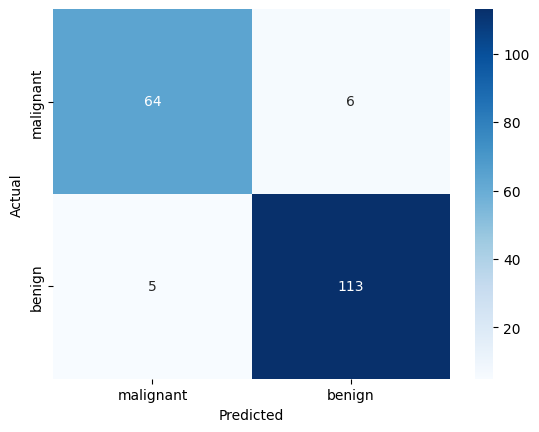

ROC AUC: 0.993


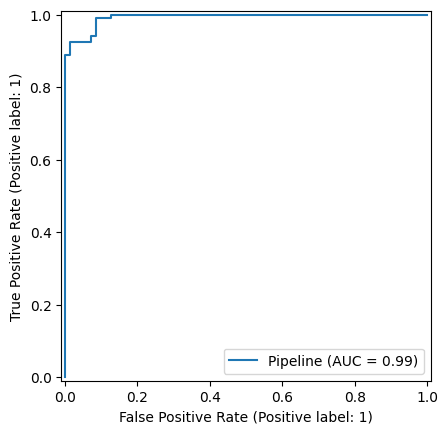

In [2]:
# Improved Cancer Cell Classification using scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# 1. Load dataset
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print("Shape of X :", X.shape)
print("Classes:", target_names)
print("Class distribution:\n", y.value_counts())

# 2. Train/test split (keeping same dataset size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

# 3. Preprocessing + feature reduction (optional)
scaler = StandardScaler()
pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance

# 4. Define model + hyperparameter grid
# Option A: Random Forest
pipe_rf = Pipeline([
    ("scaler", scaler),
    #("pca", pca),     # uncomment to use PCA
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}

# Option B: SVM
pipe_svc = Pipeline([
    ("scaler", scaler),
    #("pca", pca),
    ("clf", SVC(probability=True, random_state=42))
])

param_grid_svc = {
    "clf__C": [0.1, 1.0, 10.0],
    "clf__kernel": ["linear", "rbf"],
    "clf__gamma": ["scale", "auto"]
}

# 5. Choose which to run
do_model = "rf"  # or "svc"

if do_model == "rf":
    grid = GridSearchCV(pipe_rf, param_grid_rf, cv=5, n_jobs=-1, scoring="accuracy")
elif do_model == "svc":
    grid = GridSearchCV(pipe_svc, param_grid_svc, cv=5, n_jobs=-1, scoring="accuracy")
else:
    raise ValueError("do_model must be 'rf' or 'svc'")

# 6. Fit grid search
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy: {:.3f}".format(grid.best_score_))

# 7. Evaluate on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {roc_auc:.3f}")
    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    plt.show()